# Chess AI
## V1-Supervised

In [1]:
import os
import numpy as np 
import time
import chess
from chess import pgn
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import DataLoader 
from torch.utils.data import Dataset
from tqdm import tqdm 

# Setting up our Data

In [2]:
def load_pgn(path):
    games = []
    with open(path, 'r') as pgn_file:
        while True:
            game = chess.pgn.read_game(pgn_file)
            if game is None:
                break
            games.append(game)
    return games

files = [file for file in os.listdir("./data/") if file.endswith(".pgn")]
LIMIT_OF_FILES = min(len(files), 28)
games = []
i = 1
for file in tqdm(files):
    games.extend(load_pgn(f"./data/{file}"))
    if i >= LIMIT_OF_FILES:
        break
    i += 1

 34%|████████████████████████████                                                      | 27/79 [01:25<02:45,  3.18s/it]


In [3]:
# Change the number in LIMIT_OF_FILES for more games
print(f"Games: {len(games)}")

Games: 41570


# Encoding 
## from github.com/Skripkon

In [4]:
from chess import Board


def board_to_matrix(board: Board):
    # 8x8 is a size of the chess board.
    # 12 = number of unique pieces.
    # 13th board for legal moves (WHERE we can move)
    # maybe 14th for squares FROM WHICH we can move? idk
    matrix = np.zeros((13, 8, 8))
    piece_map = board.piece_map()

    # Populate first 12 8x8 boards (where pieces are)
    for square, piece in piece_map.items():
        row, col = divmod(square, 8)
        piece_type = piece.piece_type - 1
        piece_color = 0 if piece.color else 6
        matrix[piece_type + piece_color, row, col] = 1

    # Populate the legal moves board (13th 8x8 board)
    legal_moves = board.legal_moves
    for move in legal_moves:
        to_square = move.to_square
        row_to, col_to = divmod(to_square, 8)
        matrix[12, row_to, col_to] = 1

    return matrix


def create_input_for_nn(games):
    X = []
    y = []
    for game in games:
        board = game.board()
        for move in game.mainline_moves():
            X.append(board_to_matrix(board))
            y.append(move.uci())
            board.push(move)
    return np.array(X, dtype=np.float32), np.array(y)


def encode_moves(moves):
    move_to_int = {move: idx for idx, move in enumerate(set(moves))}
    return np.array([move_to_int[move] for move in moves], dtype=np.float32), move_to_int

In [5]:
features, labels = create_input_for_nn(games)
print(f"Number of labels: {len(labels)}")

Number of labels: 3332761


## "Feature" is a board snapshot essentially
## "Labels" is the recommended move

In [6]:
labels, move_to_int = encode_moves(labels)
num_classes = len(move_to_int)

In [7]:
features = torch.tensor(features, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)

# Initializing Dataset & Dataloader

In [8]:
class ChessDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [9]:
dataset = ChessDataset(features, labels)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Setting up our device

In [10]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


# Model

In [11]:
class ChessModelv1(nn.Module):
    def __init__(self, num_classes):
        super(ChessModelv1, self).__init__()
        self.conv1 = nn.Conv2d(13, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 8 * 128, 256)
        self.fc2 = nn.Linear(256, num_classes)

        nn.init.kaiming_uniform_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.conv2.weight, nonlinearity='relu')
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
model = ChessModelv1(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training

In [13]:
def train_model(model):
    epochs = 50
    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        print(f'Epoch {epoch + 1 + 50} / {epochs + 1 + 50}, loss: {train_loss / len(dataloader)}')

In [14]:
train_model(model)

100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [01:34<00:00, 553.95it/s]


Epoch 51 / 101, loss: 3.4119124826741687


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [01:28<00:00, 589.53it/s]


Epoch 52 / 101, loss: 2.6021883603099214


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [01:28<00:00, 589.19it/s]


Epoch 53 / 101, loss: 2.4117825283754692


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [01:28<00:00, 588.37it/s]


Epoch 54 / 101, loss: 2.3038147312943544


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [01:29<00:00, 584.98it/s]


Epoch 55 / 101, loss: 2.228696287634049


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [01:29<00:00, 583.90it/s]


Epoch 56 / 101, loss: 2.1713201399165394


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [01:28<00:00, 589.25it/s]


Epoch 57 / 101, loss: 2.1238959728177784


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [01:29<00:00, 581.68it/s]


Epoch 58 / 101, loss: 2.0833187736276817


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [01:28<00:00, 590.22it/s]


Epoch 59 / 101, loss: 2.0485852552616306


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [01:28<00:00, 589.02it/s]


Epoch 60 / 101, loss: 2.0181162209357426


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [01:28<00:00, 587.22it/s]


Epoch 61 / 101, loss: 1.9912847206378521


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [01:28<00:00, 586.79it/s]


Epoch 62 / 101, loss: 1.9669156708673852


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [01:28<00:00, 587.28it/s]


Epoch 63 / 101, loss: 1.9447675278595418


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [01:28<00:00, 587.98it/s]


Epoch 64 / 101, loss: 1.9247073517793425


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [01:28<00:00, 591.24it/s]


Epoch 65 / 101, loss: 1.9064460816042272


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [01:28<00:00, 590.36it/s]


Epoch 66 / 101, loss: 1.8895777965244398


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [01:29<00:00, 579.96it/s]


Epoch 67 / 101, loss: 1.8741262885119785


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [01:28<00:00, 589.41it/s]


Epoch 68 / 101, loss: 1.859704196502312


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [01:27<00:00, 593.04it/s]


Epoch 69 / 101, loss: 1.8467945523726728


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [01:30<00:00, 573.56it/s]


Epoch 70 / 101, loss: 1.834097831229779


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [01:32<00:00, 562.91it/s]


Epoch 71 / 101, loss: 1.8223627080175662


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [01:32<00:00, 563.00it/s]


Epoch 72 / 101, loss: 1.8113524889923092


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [02:00<00:00, 432.56it/s]


Epoch 73 / 101, loss: 1.8015025798071478


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [02:32<00:00, 341.80it/s]


Epoch 74 / 101, loss: 1.7919169950645473


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [02:33<00:00, 339.56it/s]


Epoch 75 / 101, loss: 1.7834144353202714


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [02:34<00:00, 338.08it/s]


Epoch 76 / 101, loss: 1.7747780627398553


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [02:32<00:00, 341.95it/s]


Epoch 77 / 101, loss: 1.7675396750766499


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [02:34<00:00, 337.81it/s]


Epoch 78 / 101, loss: 1.7601989843086503


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [02:33<00:00, 338.85it/s]


Epoch 79 / 101, loss: 1.75347630156729


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [02:32<00:00, 340.48it/s]


Epoch 80 / 101, loss: 1.747030588125759


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [02:32<00:00, 342.02it/s]


Epoch 81 / 101, loss: 1.7409938630860868


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [02:32<00:00, 340.41it/s]


Epoch 82 / 101, loss: 1.7351719369673122


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [02:33<00:00, 339.88it/s]


Epoch 83 / 101, loss: 1.729702103999848


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [02:33<00:00, 339.72it/s]


Epoch 84 / 101, loss: 1.7246344652029395


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [02:32<00:00, 341.91it/s]


Epoch 85 / 101, loss: 1.7194068157564146


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [02:32<00:00, 342.08it/s]


Epoch 86 / 101, loss: 1.714674416006155


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [02:32<00:00, 341.07it/s]


Epoch 87 / 101, loss: 1.7099265282393303


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [02:31<00:00, 342.61it/s]


Epoch 88 / 101, loss: 1.705523798810251


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [02:33<00:00, 339.11it/s]


Epoch 89 / 101, loss: 1.7009409975135663


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [02:33<00:00, 338.60it/s]


Epoch 90 / 101, loss: 1.6968847798465596


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [02:31<00:00, 343.24it/s]


Epoch 91 / 101, loss: 1.6924438800733936


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [02:33<00:00, 338.40it/s]


Epoch 92 / 101, loss: 1.6886911989586089


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [02:32<00:00, 341.03it/s]


Epoch 93 / 101, loss: 1.6849974718130498


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [02:32<00:00, 341.27it/s]


Epoch 94 / 101, loss: 1.6815289275622174


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [02:33<00:00, 339.22it/s]


Epoch 95 / 101, loss: 1.6780574715692609


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [02:32<00:00, 341.74it/s]


Epoch 96 / 101, loss: 1.674869121649033


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [02:33<00:00, 338.86it/s]


Epoch 97 / 101, loss: 1.6715294191451584


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [02:33<00:00, 340.25it/s]


Epoch 98 / 101, loss: 1.6688896330777578


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [02:32<00:00, 341.57it/s]


Epoch 99 / 101, loss: 1.6658615989050956


100%|███████████████████████████████████████████████████████████████████████████| 52075/52075 [02:33<00:00, 339.67it/s]

Epoch 100 / 101, loss: 1.6628663305451077


In [15]:
torch.save(model.state_dict(), "./Chess-V1.pth")

In [16]:
import pickle
with open("./heavy_move_to_int", "wb") as file:
    pickle.dump(move_to_int, file)

# Testing

In [17]:
def prepare_input(board: Board):
    matrix = board_to_matrix(board)
    features = torch.tensor(matrix, dtype=torch.float32).unsqueeze(0)
    return features

In [44]:
with open("./heavy_move_to_int", "wb") as file:
    pickle.dump(move_to_int, file)

model = ChessModelv1(num_classes=len(move_to_int))
model.load_state_dict(torch.load("./Chess-V1.pth"))
model.to(device)
model.eval()

int_to_move = {v: k for k, v in move_to_int.items()}

def predict_move(board: Board):
    features = prepare_input(board).to(device)
    
    with torch.no_grad():
        logits = model(features)
    
    logits = logits.squeeze(0) 
    
    probabilities = torch.softmax(logits, dim=0).cpu().numpy()  
    legal_moves = list(board.legal_moves)
    legal_moves_uci = [move.uci() for move in legal_moves]
    sorted_indices = np.argsort(probabilities)[::-1]
    for move_index in sorted_indices:
        move = int_to_move[move_index]
        if move in legal_moves_uci:
            return move
    
    return None

C:\Users\top\AppData\Local\Temp\ipykernel_26900\4173634059.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./Chess-V1.pth"))


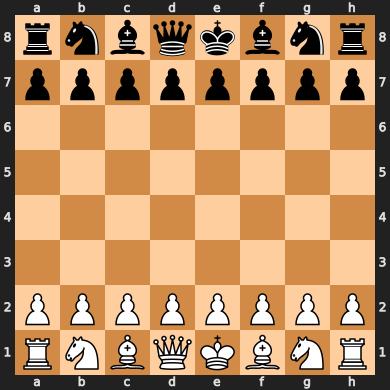

In [66]:
board = Board()
board

# Game loop
## If you want to reset run the cell above
### The results for analysis can be taken from the last cell

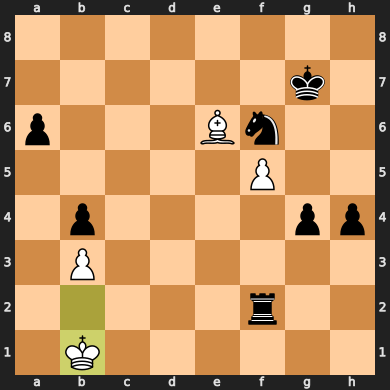

Enter your move (e.g. e2e4):  f6e5


IllegalMoveError: illegal uci: 'f6e5' in 8/6k1/p3Bn2/5P2/1p4pp/1P6/5r2/1K6 b - - 3 48

In [65]:
from IPython.display import display, clear_output

turn = chess.WHITE
color = input("White or Black?")
if color == "black":
    turn = chess.BLACK

while not board.is_game_over():
  if board.turn == turn:
    move = input("Enter your move (e.g. e2e4): ")
    if move == "exit":
        break
    board.push_uci(move)
    
  else:
    best_move = predict_move(board)
    board.push_uci(best_move)

  clear_output(wait=True)
  display(board)

In [ ]:
print(str(pgn.Game.from_board(board)))